# Experiemento Rafael


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns 
#Agglomerative wtih euclidean
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
#clustering k-means DTW
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
#Agglomerative with CTW
from tslearn.metrics import ctw_path
from scipy.spatial.distance import squareform



C:\Users\Yama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
## leitura e Tratamento dos dados
df_original = pd.read_csv("../../data/dados_extraidos.csv")

In [3]:
## carrega os dados
df = df_original.copy()

In [4]:
## pre-processamento 1 - fillna with median
# Calculo das médias do df 
medians = df.median()
# Fill NaN values with medians
df = df.fillna(medians)

display(df.head())

timestamp  vol1ex1_qx  vol1ex1_qy  vol1ex1_qz  vol1ex1_jx  vol1ex1_jy  \
0     0.0000     0.71875    102.9769    91.90424    186.9064    86.05160   
1     0.0334     0.71875    102.9769    91.90424    186.9064    86.05160   
2     0.0668    -0.25000    102.9769    91.90424    186.9064    86.24536   
3     0.1002    -0.25000    102.9769    91.90424    186.9064    85.88944   
4     0.1336     0.40625    102.9769    91.90424    186.9064    85.88944   

   vol1ex1_jz  vol1ex2_qx  vol1ex2_qy  vol1ex2_qz  ...  vol7ex4_qz  \
0    198.7182     0.71875    101.1554    100.2091  ...    308.6826   
1    198.7182     2.71875    101.1554    100.2091  ...    308.6826   
2    198.8709     2.71875    101.1554    100.2091  ...    308.6826   
3    199.3856     2.71875    101.1554    100.2091  ...    308.6826   
4    199.3856     2.50000    101.1554    100.2091  ...    308.6826   

   vol7ex4_jx  vol7ex4_jy  vol7ex4_jz  vol7ex5_qx  vol7ex5_qy  vol7ex5_qz  \
0    277.2512    219.5107    316.9044    -47.8125    131.6766    283.0572   
1    277.2512    219.5107    316.9044    -47.8125    128.9778    278.6195   
2    277.2512    219.5107    316.9044    -47.8125    128.9778    278.6195   
3    277.2512    219.5107    316.9044    -47.8125    128.8790    278.7604   
4    277.2512    219.5107    316.9044    -47.8125    128.8790    278.7604   

   vol7ex5_jx  vol7ex5_jy  vol7ex5_jz  
0    264.6223    219.5107    316.9044  
1    263.2088    219.5107    316.9044  
2    263.2088    219.5107    316.9044  
3    263.1512    219.5107    316.9044  
4    263.1512    219.5107    316.9044  

[5 rows x 211 columns]

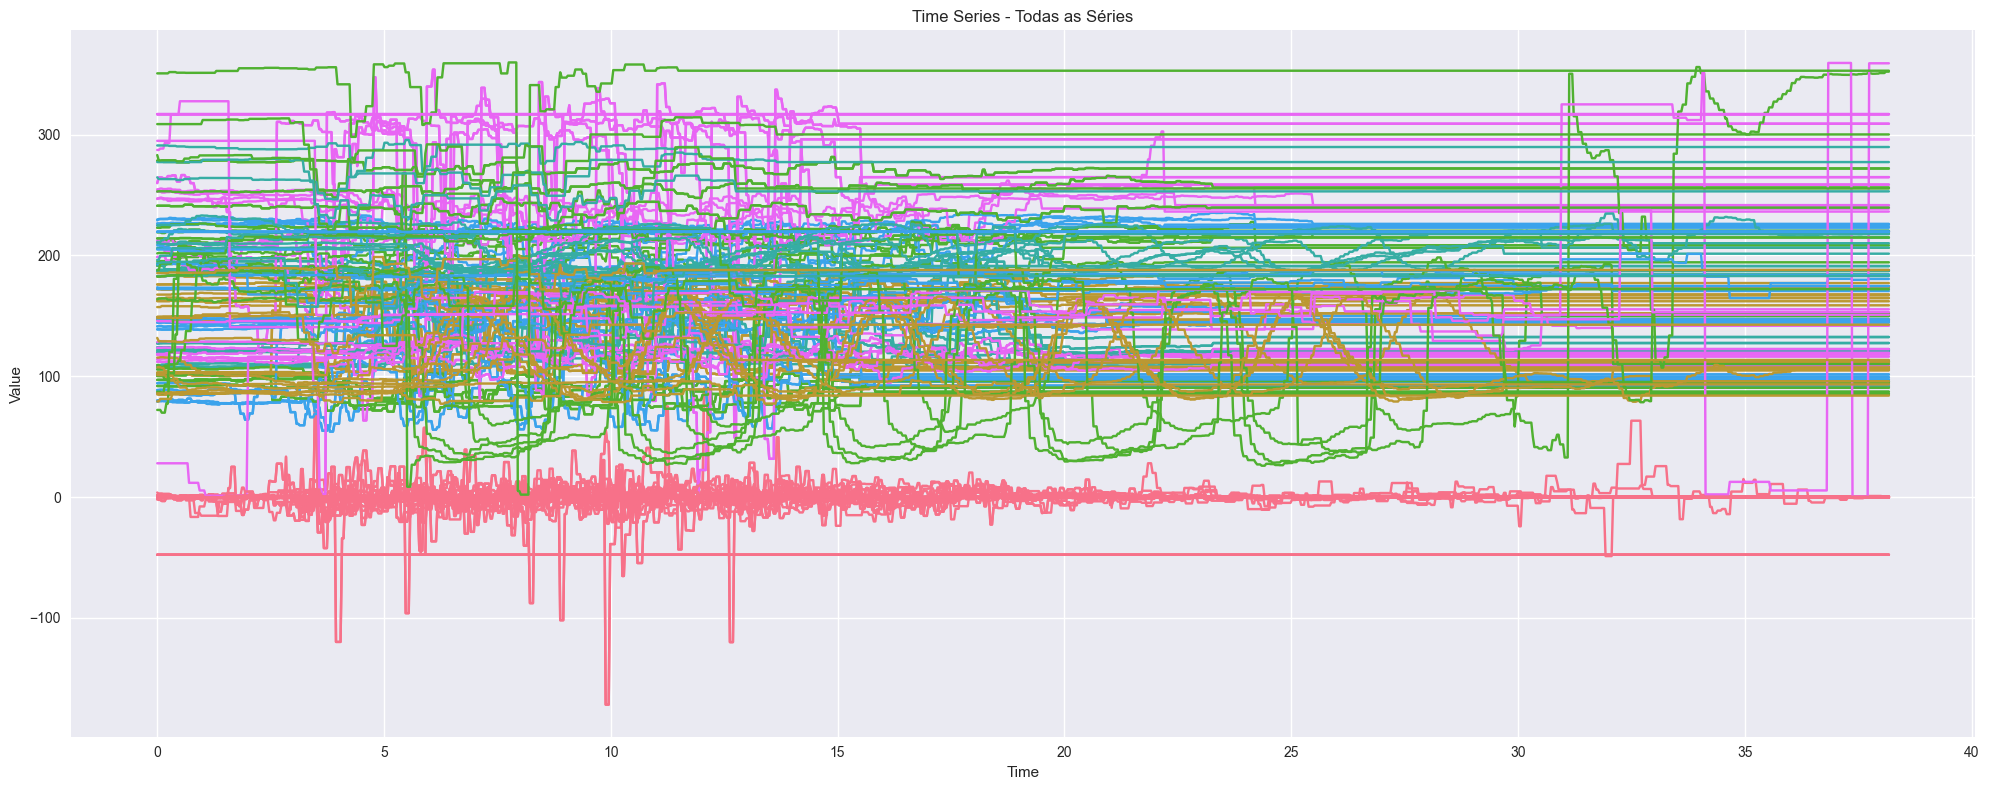

In [44]:
# visualização das séries pós processamento dos dados
plt.figure(figsize=(20, 8))

for col in df.columns[1:]:
    # Ensure the data is numeric before plotting
    df[col] = pd.to_numeric(df[col], errors='coerce')
    plt.plot(df.iloc[:,0], df[col], label=col)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series - Todas as Séries')
# plt.legend() # Remove legend
plt.grid(True)
plt.tight_layout()
plt.show() 

In [45]:
"""
suavização de cada série com média móvel
suavização de cada série com Locally Estimated Scatterplot Smoothing - LOESS (https://pypi.org/project/loess/)
"""



'\nsuavização de cada série com média móvel\nsuavização de cada série com Locally Estimated Scatterplot Smoothing - LOESS (https://pypi.org/project/loess/)\n'

In [9]:
# Parâmetro da média móvel (quantos pontos considerar)
window_size = 5  # ajuste conforme necessário

# Copiar DataFrame original para não sobrescrever
df_smoothed = df.copy()

# Aplicar média móvel a todas as colunas, exceto timestamp
series_cols = [col for col in df.columns if col != 'timestamp']

df_smoothed[series_cols] = (
    df[series_cols]
    .rolling(window=window_size, center=True, min_periods=1)
    .mean()
)

# Visualizar as primeiras linhas
df_smoothed.head()


timestamp  vol1ex1_qx  vol1ex1_qy  vol1ex1_qz  vol1ex1_jx  vol1ex1_jy  \
0     0.0000    0.395833   102.97690   91.904240   186.90640   86.116187   
1     0.0334    0.234375   102.97690   91.904240   186.90640   86.059500   
2     0.0668    0.268750   102.97690   91.904240   186.90640   86.025488   
3     0.1002    0.206250   103.04334   91.840112   186.82828   85.993056   
4     0.1336    0.143750   103.10978   91.775984   186.75016   85.968300   

   vol1ex1_jz  vol1ex2_qx  vol1ex2_qy  vol1ex2_qz  ...  vol7ex4_qz  \
0  198.769100    2.052083    101.1554  100.209100  ...    308.6826   
1  198.923225    2.218750    101.1554  100.209100  ...    308.6826   
2  199.015700    2.275000    101.1554  100.209100  ...    308.6826   
3  199.149180    2.631250    101.1734   99.627808  ...    308.6826   
4  198.539560    2.587500    101.1914   99.046516  ...    308.6826   

   vol7ex4_jx  vol7ex4_jy  vol7ex4_jz  vol7ex5_qx  vol7ex5_qy  vol7ex5_qz  \
0    277.2512    219.5107    316.9044    -47.8125   129.87740  280.098733   
1    277.2512    219.5107    316.9044    -47.8125   129.62780  279.764150   
2    277.2512    219.5107    316.9044    -47.8125   129.47804  279.563400   
3    277.2512    219.5107    316.9044    -47.8125   128.91852  278.704040   
4    277.2512    219.5107    316.9044    -47.8125   128.89876  278.732220   

   vol7ex5_jx  vol7ex5_jy  vol7ex5_jz  
0  263.679967    219.5107    316.9044  
1  263.547775    219.5107    316.9044  
2  263.468460    219.5107    316.9044  
3  263.174240    219.5107    316.9044  
4  263.162720    219.5107    316.9044  

[5 rows x 211 columns]

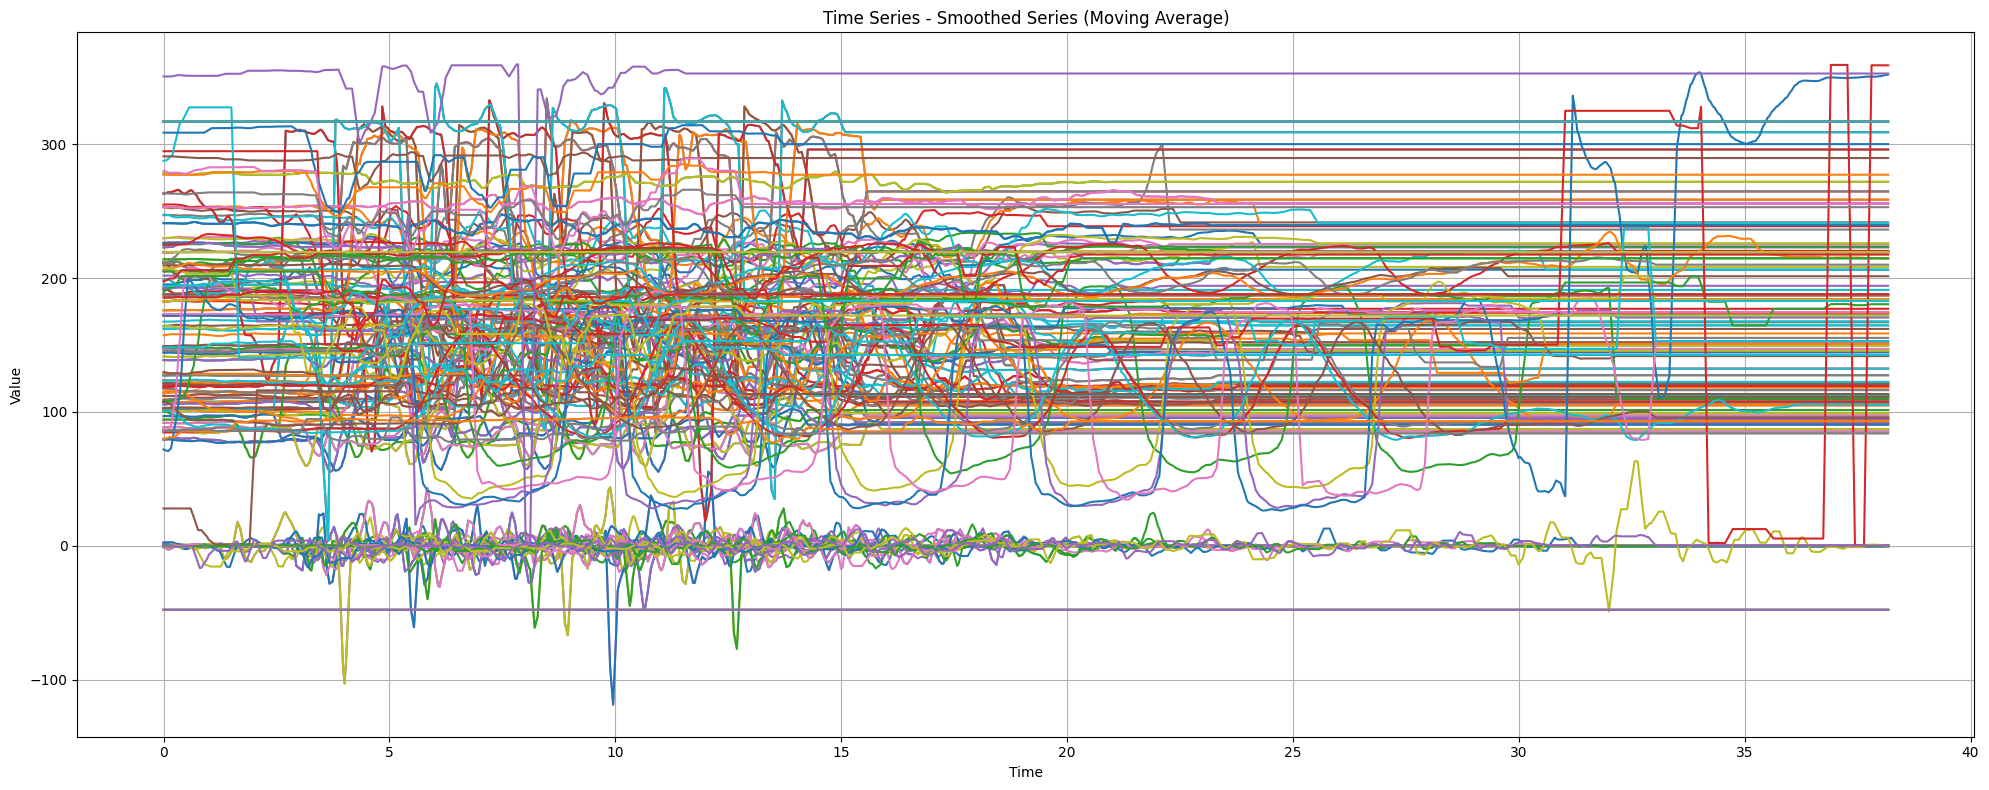

In [10]:
## visualização das séries suavizadas com média móvel
plt.figure(figsize=(20, 8))

# Select all columns except 'timestamp' from the smoothed DataFrame
smoothed_columns_to_plot = [col for col in df_smoothed.columns if col != 'timestamp']

for col in smoothed_columns_to_plot:
    plt.plot(df_smoothed['timestamp'], df_smoothed[col], label=col)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series - Smoothed Series (Moving Average)')
# plt.legend() # Uncomment to show legend if needed
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from loess.loess_1d import loess_1d
import logging

# Configurar logging básico
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')

# Parâmetros do LOESS
frac = 0.1    # Fração de pontos para cada ajuste local (0.1 a 1.0)
degree = 1    # Grau do polinômio
npoints = None  # Número de pontos (None = automático)

# Lista de colunas originais (exceto timestamp)
original_cols = [col for col in df.columns if col != 'timestamp']

# Pré-alocar dicionário de resultados
smoothed_data = {'timestamp': df['timestamp']}
x_values = np.arange(len(df), dtype=float)

for i, col in enumerate(original_cols):
    try:
        y_values = df[col].values.astype(float)
        
        if np.isnan(y_values).all():
            smoothed_data[col + '_smoothed_loess'] = y_values
            continue
        
        valid_mask = ~np.isnan(y_values)
        n_valid = np.sum(valid_mask)

        if n_valid < 3:
            smoothed_data[col + '_smoothed_loess'] = y_values
            continue

        min_points_needed = max(3, int(n_valid * 0.1))
        local_frac = frac if n_valid * frac >= min_points_needed else min_points_needed / n_valid

        x_clean = x_values[valid_mask]
        y_clean = y_values[valid_mask]

        data_range = np.max(y_clean) - np.min(y_clean)
        data_std = np.std(y_clean)

        if data_range < 1e-10 or data_std < 1e-10:
            smoothed_data[col + '_smoothed_loess'] = y_values
            continue

        try:
            _, yout, _ = loess_1d(x_clean, y_clean, degree=degree, frac=local_frac, npoints=npoints)
        except Exception as loess_error:
            if "SVD did not converge" in str(loess_error):
                try:
                    alt_frac = min(0.8, local_frac + 0.3)
                    _, yout, _ = loess_1d(x_clean, y_clean, degree=1, frac=alt_frac, npoints=npoints)
                except:
                    window_size = max(3, int(len(y_clean) * 0.1))
                    yout = pd.Series(y_clean).rolling(window=window_size, center=True, min_periods=1).mean().values
            else:
                raise loess_error

        smoothed_series = np.full_like(y_values, np.nan, dtype=float)
        smoothed_series[valid_mask] = yout

        if np.isnan(smoothed_series).any():
            valid_smoothed = ~np.isnan(smoothed_series)
            if np.sum(valid_smoothed) > 1:
                smoothed_series = np.interp(x_values, x_values[valid_smoothed], smoothed_series[valid_smoothed])

        smoothed_data[col + '_smoothed_loess'] = smoothed_series

    except Exception as e:
        logging.error(f'Erro ao processar coluna {col}: {e}')
        smoothed_data[col + '_smoothed_loess'] = y_values

# Construir DataFrame final
df_smoothed_loess = pd.DataFrame(smoothed_data)

# Salvar resultado
output_filename = f'dataset_suavizado_loess_frac{frac}_deg{degree}.csv'
df_smoothed_loess.to_csv(output_filename, index=False)

# Verificação simples de séries mantidas
total_errors = sum(
    np.allclose(df[col].values, df_smoothed_loess[col + '_smoothed_loess'].values, equal_nan=True)
    for col in original_cols
)
total_processed = len(original_cols)
processing_success_rate = ((total_processed - total_errors) / total_processed) * 100

logging.info(f'Séries suavizadas: {total_processed - total_errors}/{total_processed} ({processing_success_rate:.1f}%)')
logging.info(f'Saída salva em: {output_filename}')


[INFO] Séries suavizadas: 195/210 (92.9%)
[INFO] Saída salva em: dataset_suavizado_loess_frac0.1_deg1.csv


In [8]:
## visualização das séries novamente depois dos preprocessamentos novos e escolhe uma

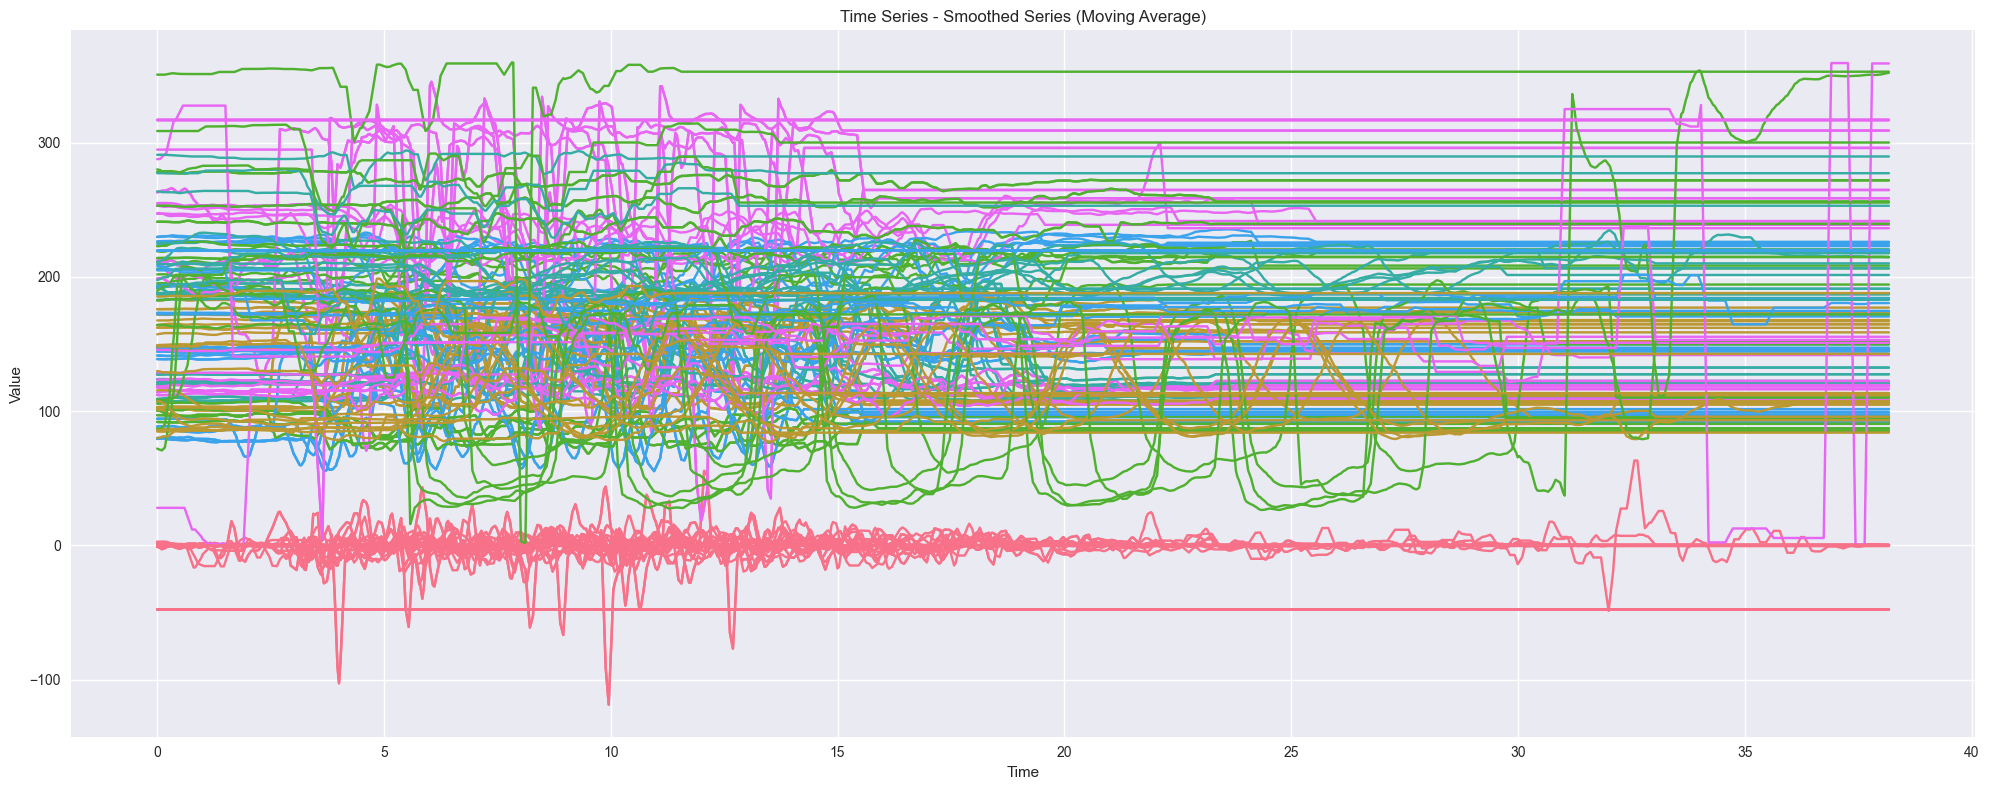

In [51]:
## visualização das séries suavizadas com média móvel
plt.figure(figsize=(20, 8))

# Select all columns except 'timestamp' from the smoothed DataFrame
smoothed_columns_to_plot = [col for col in df_smoothed.columns if col != 'timestamp']

for col in smoothed_columns_to_plot:
    plt.plot(df_smoothed['timestamp'], df_smoothed[col], label=col)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series - Smoothed Series (Moving Average)')
# plt.legend() # Uncomment to show legend if needed
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
"""
seguir o notebook de exemplo notebooks\Legacy\01_angulos_por_voluntario\04_Joelho_todos.ipynb

plot joelho com todos os voluntário e trials (cor por voluntário)
plot quadril com todos os voluntário e trials (cor por voluntário)
"""

'\nseguir o notebook de exemplo notebooks\\Legacy\x01_angulos_por_voluntario\x04_Joelho_todos.ipynb\n\nplot joelho com todos os voluntário e trials (cor por voluntário)\nplot quadril com todos os voluntário e trials (cor por voluntário)\n'

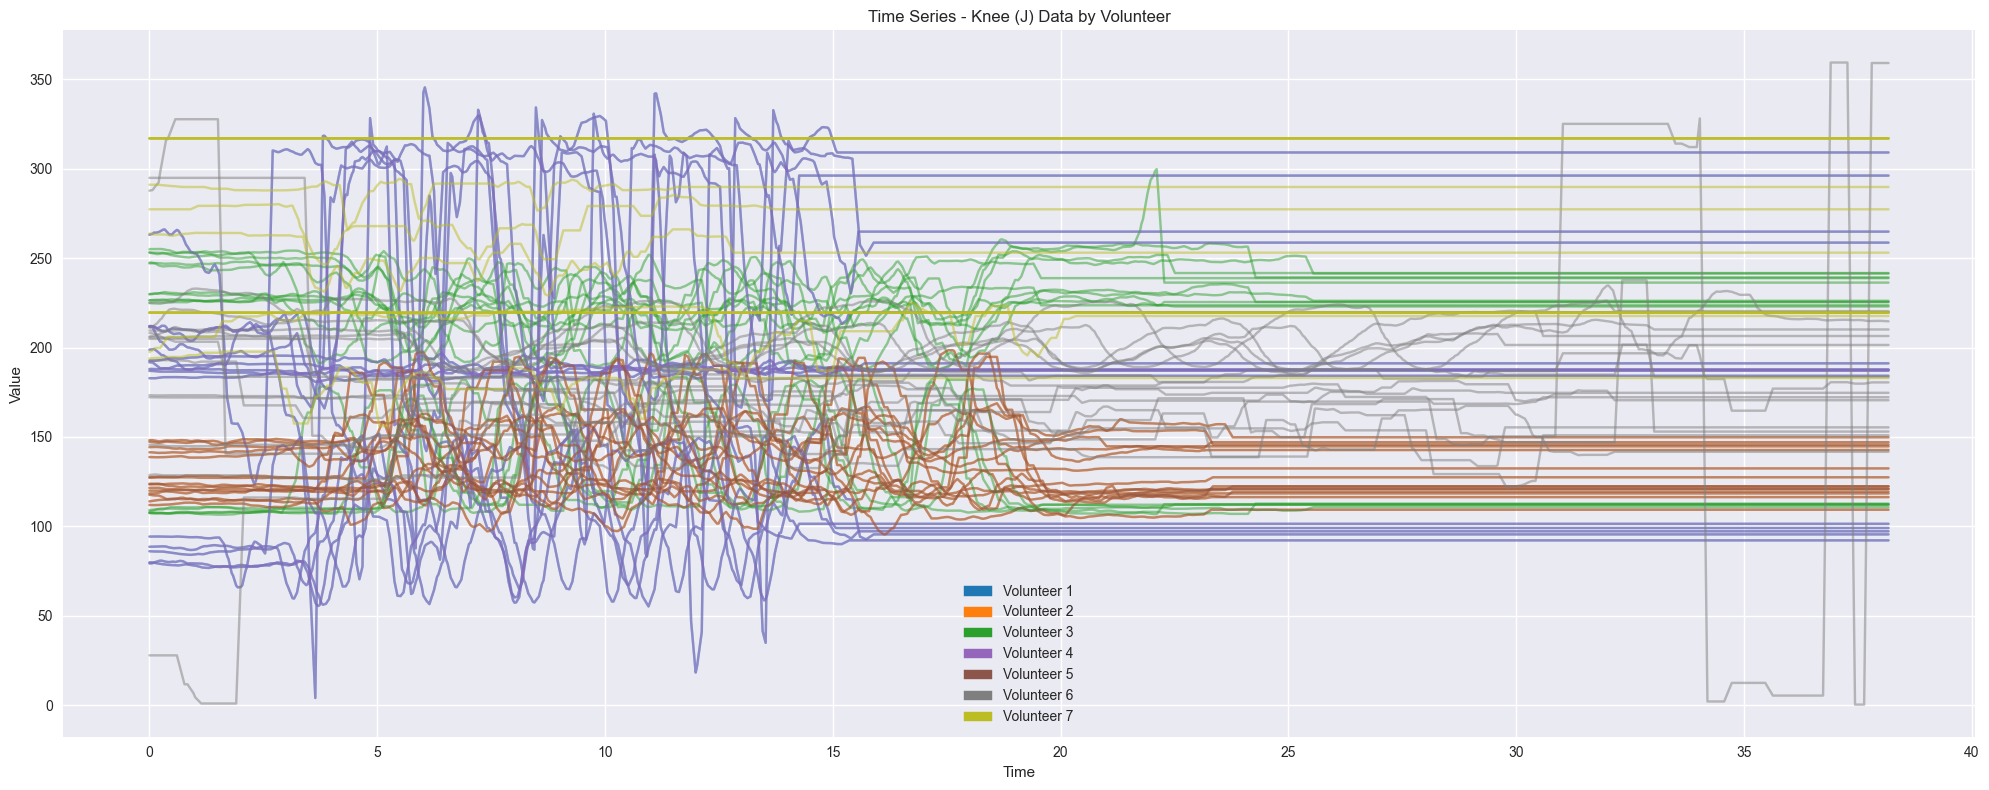

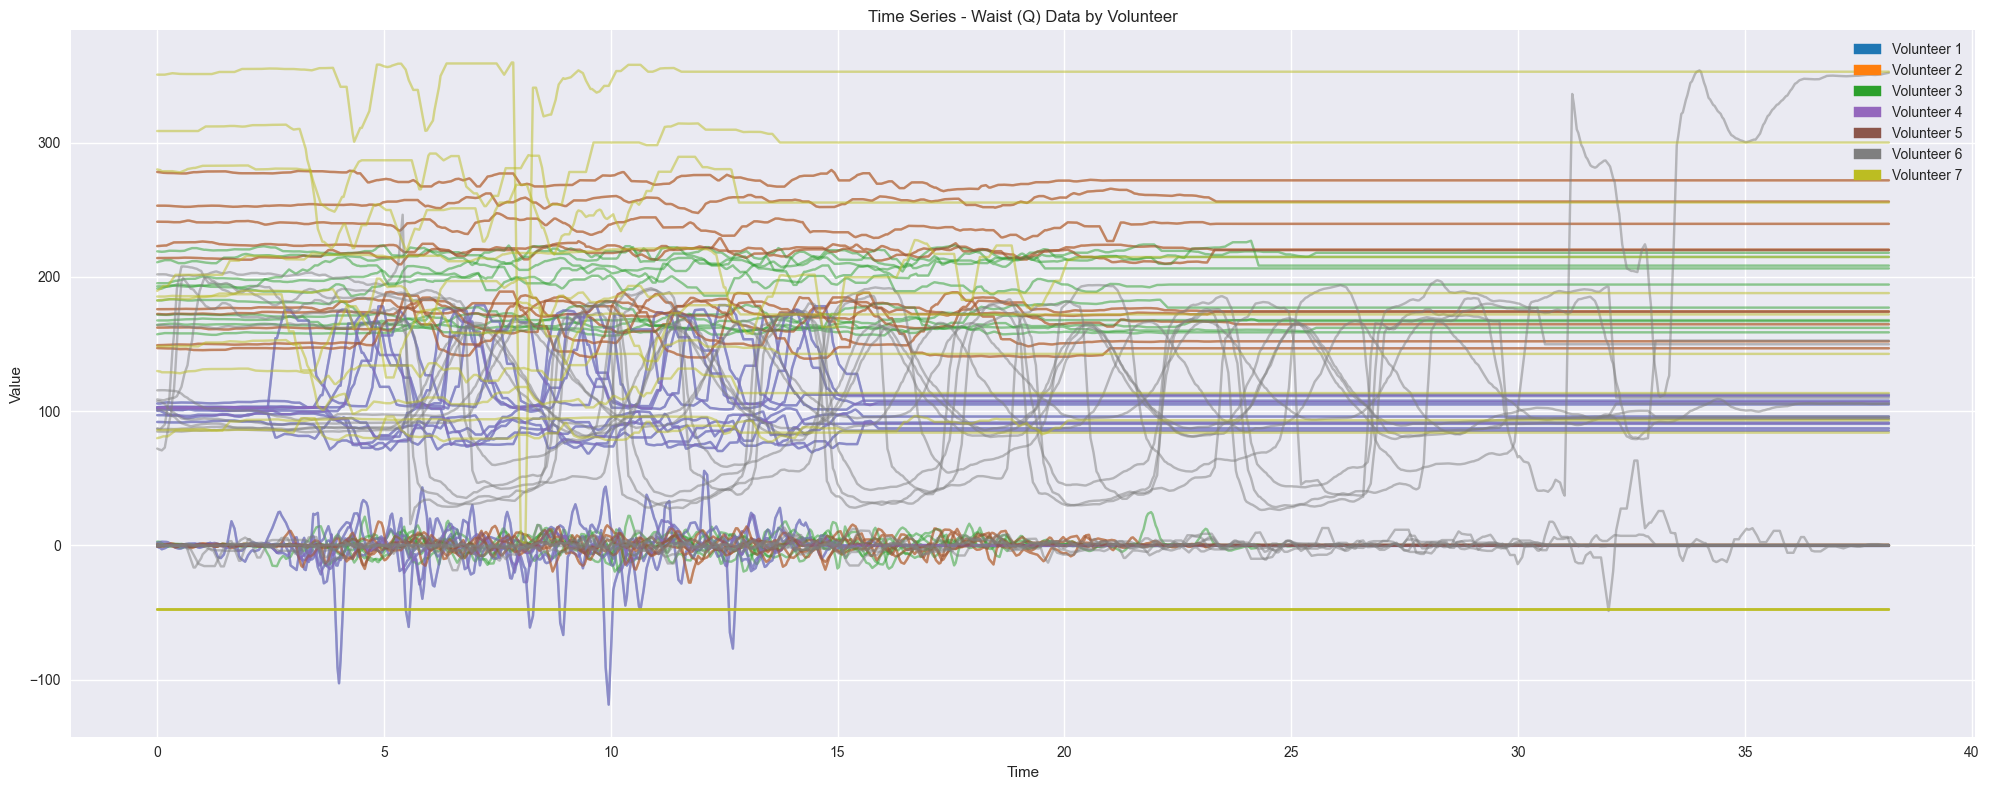

In [52]:
import matplotlib.patches as mpatches

## plot joelho com todos os voluntário e trials (cor por voluntário)
## plot quadril com todos os voluntário e trials (cor por voluntário)

# Get unique volunteer numbers from column names (assuming format vol[number]...)
volunteer_numbers = sorted(list(set([col.split('ex')[0][3:] for col in df.columns if 'vol' in col])))

# color_map para o plot
colors = plt.colormaps.get_cmap('tab10')
color_map = {vol_num: colors(i/len(volunteer_numbers)) for i, vol_num in enumerate(volunteer_numbers)}

# Plot Jxyz series (Knee)
plt.figure(figsize=(20, 8))
j_columns = [col for col in df.columns if '_j' in col.lower()]

# Create legend handles and labels for J series
legend_handles_j = []
legend_labels_j = []

for col in j_columns:
    vol_num = col.split('ex')[0][3:]
    if vol_num in color_map:
        plt.plot(df_smoothed['timestamp'], df_smoothed[col], color=color_map[vol_num], alpha=0.5) # Plot with some transparency
        if vol_num not in legend_labels_j:
            legend_handles_j.append(mpatches.Patch(color=color_map[vol_num], label=f'Volunteer {vol_num}'))
            legend_labels_j.append(vol_num)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series - Knee (J) Data by Volunteer')
plt.legend(handles=legend_handles_j) # Use custom legend handles
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Qxyz series (Waist)
plt.figure(figsize=(20, 8))
q_columns = [col for col in df.columns if '_q' in col.lower()]

# Create legend handles and labels for Q series
legend_handles_q = []
legend_labels_q = []

for col in q_columns:
    vol_num = col.split('ex')[0][3:]
    if vol_num in color_map:
        plt.plot(df_smoothed['timestamp'], df_smoothed[col], color=color_map[vol_num], alpha=0.5) # Plot with some transparency
        if vol_num not in legend_labels_q:
            legend_handles_q.append(mpatches.Patch(color=color_map[vol_num], label=f'Volunteer {vol_num}'))
            legend_labels_q.append(vol_num)


plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series - Waist (Q) Data by Volunteer')
plt.legend(handles=legend_handles_q) # Use custom legend handles
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Clusterização hierárquica

In [11]:
"""
calcular uma matriz de distância entre as séries. Distâncias:
    - a distância vai ser: soma das distancias euclidiana das univariadas (dist joelho x + joelho y + joelho z + quadril x + quadril y + quadril z) 
        (entre duas trials, igualzinho o que vc já fez antes, só qeu agora considerando todas as variáveis (série temporal **multivariada**)
    - usa clusterização hierárquica aglomerativa (sklearn.cluster.AgglomerativeClustering)
    - escolhe um corte e visualiza os clusters
"""

'\ncalcular uma matriz de distância entre as séries. Distâncias:\n    - a distância vai ser: soma das distancias euclidiana das univariadas (dist joelho x + joelho y + joelho z + quadril x + quadril y + quadril z) \n        (entre duas trials, igualzinho o que vc já fez antes, só qeu agora considerando todas as variáveis (série temporal **multivariada**)\n    - usa clusterização hierárquica aglomerativa (sklearn.cluster.AgglomerativeClustering)\n    - escolhe um corte e visualiza os clusters\n'

🔄 Calculando matriz de distância multivariada...
   Progresso: 0.0% (0/1144 amostras)
   Progresso: 0.9% (10/1144 amostras)
   Progresso: 1.7% (20/1144 amostras)
   Progresso: 2.6% (30/1144 amostras)
   Progresso: 3.5% (40/1144 amostras)
   Progresso: 4.4% (50/1144 amostras)
   Progresso: 5.2% (60/1144 amostras)
   Progresso: 6.1% (70/1144 amostras)
   Progresso: 7.0% (80/1144 amostras)
   Progresso: 7.9% (90/1144 amostras)
   Progresso: 8.7% (100/1144 amostras)
   Progresso: 9.6% (110/1144 amostras)
   Progresso: 10.5% (120/1144 amostras)
   Progresso: 11.4% (130/1144 amostras)
   Progresso: 12.2% (140/1144 amostras)
   Progresso: 13.1% (150/1144 amostras)
   Progresso: 14.0% (160/1144 amostras)
   Progresso: 14.9% (170/1144 amostras)
   Progresso: 15.7% (180/1144 amostras)
   Progresso: 16.6% (190/1144 amostras)
   Progresso: 17.5% (200/1144 amostras)
   Progresso: 18.4% (210/1144 amostras)
   Progresso: 19.2% (220/1144 amostras)
   Progresso: 20.1% (230/1144 amostras)
   Progresso: 

C:\Users\Yama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


✅ Clustering concluído! 4 clusters identificados
📊 Criando dendrograma...


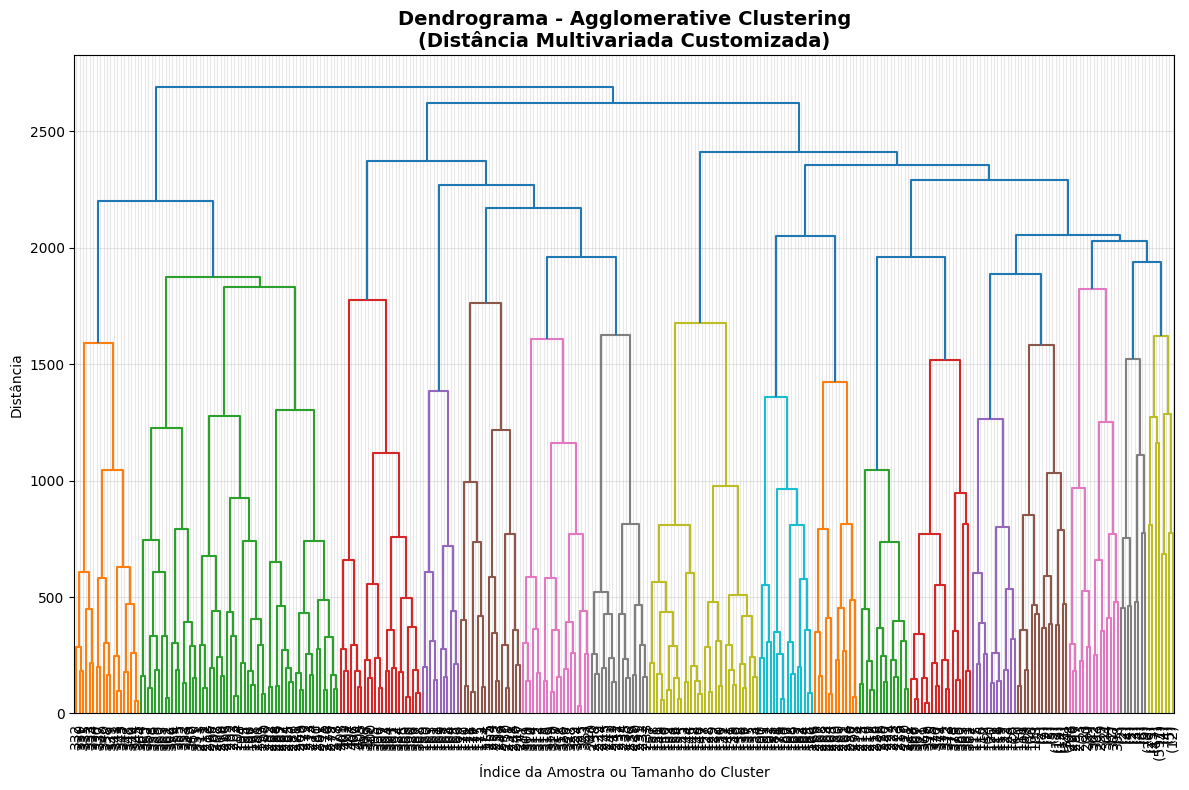

'# ----- Análise dos Resultados -----\nprint("\n" + "="*60)\nprint("🔍 ANÁLISE DOS RESULTADOS")\nprint("="*60)\n\n# Distribuição dos clusters\nunique_labels, counts = np.unique(labels, return_counts=True)\nprint(f"\n📊 Distribuição dos Clusters:")\nfor cluster, count in zip(unique_labels, counts):\n    percentage = (count / len(labels)) * 100\n    print(f"   Cluster {cluster}: {count} amostras ({percentage:.1f}%)")\n\n# Visualização da distribuição\nplt.figure(figsize=(10, 6))\nplt.bar(unique_labels, counts, alpha=0.7, color=\'skyblue\', edgecolor=\'black\')\nplt.title("Distribuição dos Clusters", fontsize=14, fontweight=\'bold\')\nplt.xlabel("Cluster ID")\nplt.ylabel("Número de Amostras")\nplt.grid(True, alpha=0.3, axis=\'y\')\n\n# Adicionar rótulos nas barras\nfor i, (cluster, count) in enumerate(zip(unique_labels, counts)):\n    plt.text(cluster, count + 0.5, str(count), ha=\'center\', va=\'bottom\', fontweight=\'bold\')\n\nplt.tight_layout()\nplt.show()'

In [13]:
data = df.drop(columns=["timestamp"]).values  # .values em vez de .to_numpy()
# ----- Calcular matriz de distância multivariada -----
print("🔄 Calculando matriz de distância multivariada...")
n = data.shape[0]
dist_matrix_euclidean = np.zeros((n, n))

# Lógica para calcular distâncias
for i in range(n):
    if i % 10 == 0:
        progress = (i / n) * 100
        print(f"   Progresso: {progress:.1f}% ({i}/{n} amostras)")
    
    for j in range(i+1, n):
        dist = 0
        
        # OPÇÃO A: Se você quer agrupar as features em grupos de 6 (qx,qy,qz,jx,jy,jz)
        # e calcular distâncias para cada componente separadamente
        for k in range(0, data.shape[1], 6):
            # Verifica se ainda há pelo menos 6 features
            if k + 5 < data.shape[1]:
                # Distância para componentes q (quaternions): indices 0,1,2
                q_features_i = data[i, k:k+3]  # qx, qy, qz
                q_features_j = data[j, k:k+3]
                dist += euclidean(q_features_i, q_features_j)
                
                # Distância para componentes j (joints): indices 3,4,5
                j_features_i = data[i, k+3:k+6]  # jx, jy, jz
                j_features_j = data[j, k+3:k+6]
                dist += euclidean(j_features_i, j_features_j)
            else:
                # Para features restantes (se não completam um grupo de 6)
                remaining_features = data.shape[1] - k
                if remaining_features > 0:
                    remaining_i = data[i, k:k+remaining_features]
                    remaining_j = data[j, k:k+remaining_features]
                    dist += euclidean(remaining_i, remaining_j)
        
        # OPÇÃO B: Alternativa mais simples - distância euclidiana direta
        # dist = euclidean(data[i], data[j])
        
        dist_matrix_euclidean[i, j] = dist_matrix_euclidean[j, i] = dist

print("✅ Matriz de distância calculada!")

# Verificar se a matriz 
print(f"📊 Estatísticas da matriz de distância:")
print(f"   Min: {dist_matrix_euclidean[dist_matrix_euclidean > 0].min():.3f}")
print(f"   Max: {dist_matrix_euclidean.max():.3f}")
print(f"   Média: {dist_matrix_euclidean[dist_matrix_euclidean > 0].mean():.3f}")

# ----- Clusterização Aglomerativa -----
print("🔗 Executando Clusterização Aglomerativa...")
n_clusters = 4  # definir número desejado
model = AgglomerativeClustering(
    n_clusters=n_clusters,  
    linkage='average'
)
labels = model.fit_predict(dist_matrix_euclidean)

print(f"✅ Clustering concluído! {n_clusters} clusters identificados")

# ----- Visualizar Dendrograma -----
print("📊 Criando dendrograma...")
plt.figure(figsize=(12, 8))

# CORREÇÃO 5: Converter matriz quadrada para formato condensado
from scipy.spatial.distance import squareform
condensed_dist = squareform(dist_matrix_euclidean, checks=False)
linked_euclidean = linkage(condensed_dist, method='average')

dendrogram(linked_euclidean, 
           truncate_mode='level',
           p=10,  # Mostrar apenas os últimos 10 níveis
           leaf_rotation=90,
           leaf_font_size=10)
plt.title("Dendrograma - Agglomerative Clustering\n(Distância Multivariada Customizada)", 
          fontsize=14, fontweight='bold')
plt.xlabel("Índice da Amostra ou Tamanho do Cluster")
plt.ylabel("Distância")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

"""# ----- Análise dos Resultados -----
print("\n" + "="*60)
print("🔍 ANÁLISE DOS RESULTADOS")
print("="*60)

# Distribuição dos clusters
unique_labels, counts = np.unique(labels, return_counts=True)
print(f"\n📊 Distribuição dos Clusters:")
for cluster, count in zip(unique_labels, counts):
    percentage = (count / len(labels)) * 100
    print(f"   Cluster {cluster}: {count} amostras ({percentage:.1f}%)")

# Visualização da distribuição
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, counts, alpha=0.7, color='skyblue', edgecolor='black')
plt.title("Distribuição dos Clusters", fontsize=14, fontweight='bold')
plt.xlabel("Cluster ID")
plt.ylabel("Número de Amostras")
plt.grid(True, alpha=0.3, axis='y')

# Adicionar rótulos nas barras
for i, (cluster, count) in enumerate(zip(unique_labels, counts)):
    plt.text(cluster, count + 0.5, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()"""


In [ ]:
# Clusterização k-means DTW
"""
- para n_clusters em [2, 8]:
    - clusteriza com o DTW
    - calcula métricas (silhouette score, inertia)
- analiza regra do cotovelo e escolhe um número de clusters
- visualiza clusters
"""

'\n- para n_clusters em [2, 10]:\n    - clusteriza com o DTW\n    - calcula métricas (silhouette score, inertia)\n- analiza regra do cotovelo e escolhe um número de clusters\n- visualiza clusters\n'

In [ ]:
# Prepare data for clustering
# Seleciona apenas as colunas de séries (exclui timestamp)
df_T = df.T
# séries temporais (linhas 1 a n)
series = df_T.iloc[1:].values

# Aplica o StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(series)
n_range = range(2, 7)
results = []

for k in n_range:
    km_dtw = TimeSeriesKMeans(
        n_clusters=k,
        metric="dtw",
        max_iter=50,
        random_state=42
    )
    labels = km_dtw.fit_predict(X_scaled)
    print(f"[Checkpoint] Clusterização para k={k} finalizada.")

    # Inertia vem direto do modelo
    inertia = km_dtw.inertia_
    
    # Silhouette Score precisa receber 2D array
    silhouette = silhouette_score(X_scaled, labels)

    results.append((k, inertia, silhouette))

# Salvar resultados em DataFrame
df_results = pd.DataFrame(results, columns=["n_clusters", "inertia", "silhouette"])
df_results


[Checkpoint] Clusterização para k=2 finalizada.
[Checkpoint] Clusterização para k=3 finalizada.


n_clusters     inertia  silhouette
0           2  208.741208    0.523711
1           3   69.525038    0.579382

In [ ]:
# Clusterização k-means CTW
"""
- para n_clusters em [2, 8]:
    - clusteriza com o CTW
    - calcula métricas (silhouette score, inertia)
- analiza regra do cotovelo e escolhe um número de clusters
- visualiza clusters
"""

'\n- para n_clusters em [2, 10]:\n    - clusteriza com o CTW\n    - calcula métricas (silhouette score, inertia)\n- analiza regra do cotovelo e escolhe um número de clusters\n- visualiza clusters\n'

Calculando distâncias CTW...
Processadas 5/35 séries
Processadas 10/35 séries
Processadas 15/35 séries
Processadas 20/35 séries
Processadas 25/35 séries
Processadas 30/35 séries
Processadas 35/35 séries


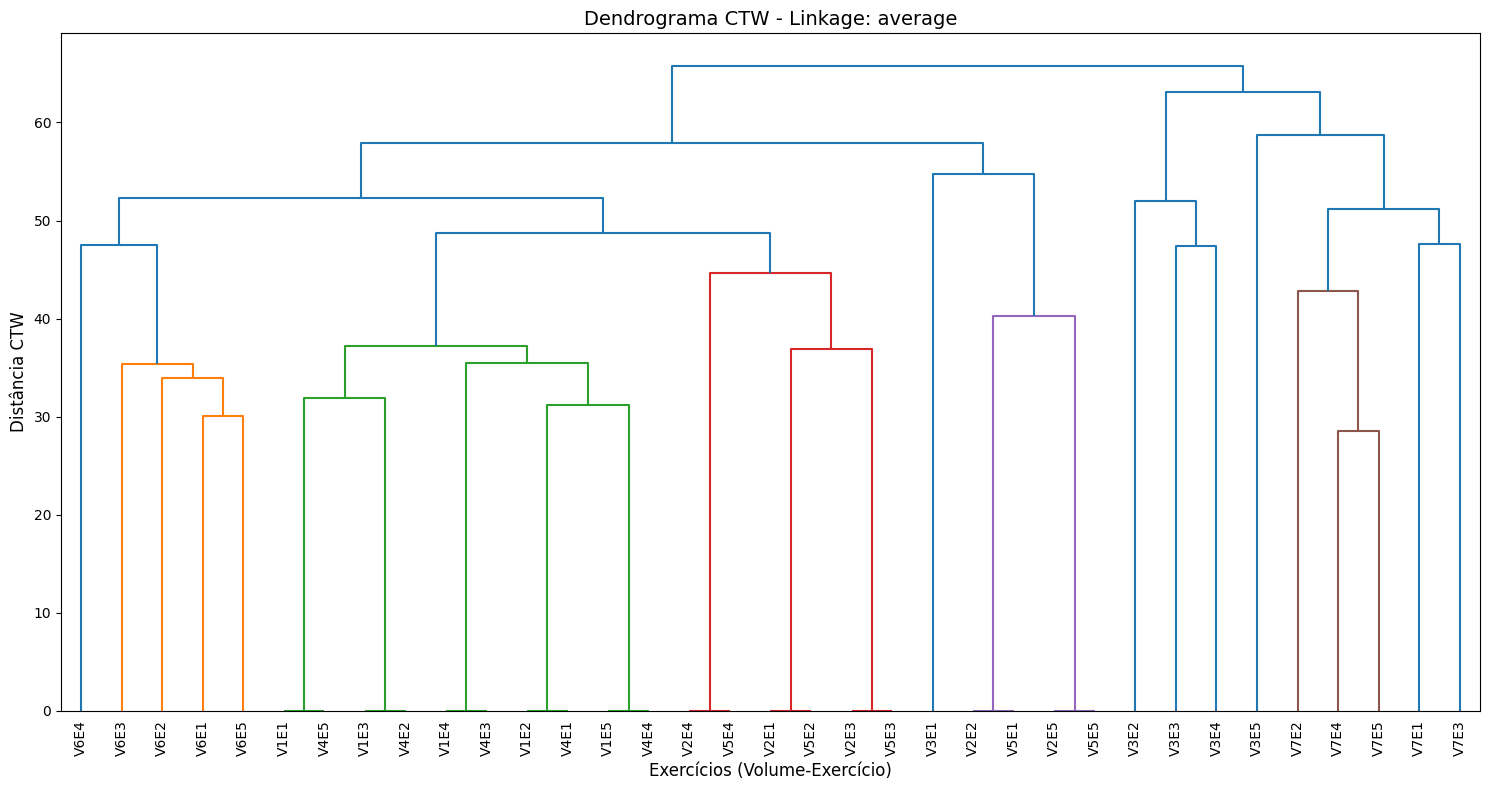

In [ ]:
def plot_ctw_dendrogram(df, linkage_method='average'):
    series = df.iloc[:, 1:].values
    
    n_features = 6
    n_exercises = 5
    n_volumes = 7
    n_timesteps = series.shape[0]
    
    X_3d = series.reshape(n_timesteps, n_volumes * n_exercises, n_features)
    
    scaler = StandardScaler()
    X_scaled = np.zeros_like(X_3d)
    for i in range(n_features):
        X_scaled[:, :, i] = scaler.fit_transform(X_3d[:, :, i])
    
    X_series = X_scaled.transpose(1, 0, 2)
    n_samples = X_series.shape[0]
    
    dist_matrix_ctw = np.zeros((n_samples, n_samples))
    
    print("Calculando distâncias CTW...")
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            path_ctw, cca, dist = ctw_path(X_series[i], X_series[j],
                                         max_iter=100, n_components=min(6, 3))
            dist_matrix_ctw[i, j] = dist_matrix_ctw[j, i] = dist
        if (i+1) % 5 == 0:
            print(f"Processadas {i+1}/{n_samples} séries")
    
    # Convert distance matrix to condensed form for linkage
    condensed_dist = squareform(dist_matrix_ctw)
    
    # Perform hierarchical clustering
    Z = linkage(condensed_dist, method=linkage_method)
    
    # Create labels for exercises and volumes
    labels = []
    for vol in range(1, n_volumes + 1):
        for ex in range(1, n_exercises + 1):
            labels.append(f'V{vol}E{ex}')
    
    # Plot dendrogram
    plt.figure(figsize=(15, 8))
    dendrogram(Z, labels=labels, leaf_rotation=90, leaf_font_size=10)
    plt.title(f'Dendrograma CTW - Linkage: {linkage_method}', fontsize=14)
    plt.xlabel('Exercícios (Volume-Exercício)', fontsize=12)
    plt.ylabel('Distância CTW', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return Z, dist_matrix_ctw, labels

Z, dist_matrix_ctw, labels = plot_ctw_dendrogram(df)

In [ ]:
""""import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from tslearn.clustering import KMeans
from tslearn.metrics import ctw_path  # pip install ctw


# Prepare data for clustering
# Seleciona apenas as colunas de séries (exclui timestamp)
df_T = df.T
# séries temporais (linhas 1 a n)
series = df_T.iloc[1:].values

# Aplica o StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(series)

# Ajustar para formato (n_amostras, comprimento, n_features)
n_features = 6  # joelho x,y,z + quadril x,y,z
length = X_raw.shape[1] // n_features
X_series = X_raw.reshape(X_raw.shape[0], length, n_features)

# Escalonar
scaler = StandardScaler()
X_scaled = np.empty_like(X_series)
for f in range(n_features):
    X_scaled[:,:,f] = scaler.fit_transform(X_series[:,:,f])

# --- Calcular matriz de distâncias CTW ---
n_samples = X_scaled.shape[0]
dist_matrix_ctw = np.zeros((n_samples, n_samples))

for i in range(n_samples):
    for j in range(i+1, n_samples):
        ctw = CanonicalTimeWarping()
        ctw.fit(X_scaled[i], X_scaled[j])
        dist = ctw.distance(X_scaled[i], X_scaled[j])
        dist_matrix_ctw[i, j] = dist_matrix_ctw[j, i] = dist

# --- Converter distâncias para embedding MDS ---
embedding = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
X_embedded = embedding.fit_transform(dist_matrix_ctw)

# --- Avaliar K-Means para k em [2, 10] ---
n_range = range(2, 8)
results = []

for k in n_range:
    km_ctw = KMeans(n_clusters=k, random_state=42)
    labels = km_ctw.fit_predict(X_embedded)
    inertia = km_ctw.inertia_
    sil = silhouette_score(X_embedded, labels)
    results.append((k, inertia, sil))

# --- Resultados ---
df_results = pd.DataFrame(results, columns=["n_clusters", "inertia", "silhouette"])
df_results
""""

C:\Users\Yama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


ImportError: cannot import name 'KMeans' from 'tslearn.clustering' (C:\Users\Yama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tslearn\clustering\__init__.py)

In [ ]:
""""import numpy as np
import pandas as pd
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import ctw_path
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

def apply_ctw_clustering(df):
    # Remove timestamp column
    series = df.iloc[:, 1:].values
    
    n_features = 6  # 3 joint + 3 quaternion per exercise
    n_exercises = 5
    n_volumes = 7
    total_features = n_volumes * n_exercises * n_features  # 210
    n_timesteps = series.shape[0]
    
    # Reshape to 3D: (timesteps, exercises*volumes, features_per_exercise)
    # Group every 6 features together (xyz joint + xyz quaternion)
    X_3d = series.reshape(n_timesteps, n_volumes * n_exercises, n_features)
    
    # Standardize each feature dimension
    scaler = StandardScaler()
    X_scaled = np.zeros_like(X_3d)
    for i in range(n_features):
        X_scaled[:, :, i] = scaler.fit_transform(X_3d[:, :, i])
    
    # For CTW, we need to treat each exercise*volume combination as a separate time series
    # Transpose to get (exercises*volumes, timesteps, features)
    X_series = X_scaled.transpose(1, 0, 2)
    n_samples = X_series.shape[0]  # 35 series (7vol * 5ex)
    
    # Compute CTW distance matrix
    dist_matrix = np.zeros((n_samples, n_samples))
    
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            # Each series is (timesteps, 6_features)
            path_ctw, cca, dist = ctw_path(X_series[i], X_series[j],
                                         max_iter=100, n_components=min(6, 3))
            dist_matrix[i, j] = dist_matrix[j, i] = dist
    
    # Clustering evaluation
    n_range = range(2, min(8, n_samples))
    results = []
    
    for k in n_range:
        km_ctw = TimeSeriesKMeans(
            n_clusters=k,
            metric="precomputed",
            max_iter=50,
            random_state=42
        )
        
        labels = km_ctw.fit_predict(dist_matrix)
        print(f"[Checkpoint] Clusterização para k={k} finalizada.")
        
        inertia = km_ctw.inertia_
        # For silhouette, use the original series reshaped to 2D
        X_2d = X_series.reshape(n_samples, -1)
        silhouette = silhouette_score(X_2d, labels)
        
        results.append((k, inertia, silhouette))
    
    df_results = pd.DataFrame(results, columns=["n_clusters", "inertia", "silhouette"])
    return df_results, X_series, dist_matrix

df_results, X_series, dist_matrix_ctw = apply_ctw_clustering(df)""""

C:\Users\Yama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Yama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ValueError: Incorrect metric: precomputed (should be one of 'dtw', 'softdtw', 'euclidean')

In [46]:
# Análise dos resultados
"""
Compara o que vc obteve com 3 métodos acima.
"""

"""
Hipótese: Clusterizar séries temporais é útil para detectar padrões de compensação de movimento nos dados do BSN?
Pra responder:
- experimento comparando métodos de clusterização para encontrar o melhor deles.
- **analisar se a clusterização foi de fato útil ou não**.
"""

'\nHipótese: Clusterizar séries temporais é útil para detectar padrões de compensação de movimento nos dados do BSN?\nPra responder:\n- experimento comparando métodos de clusterização para encontrar o melhor deles.\n- **analisar se a clusterização foi de fato útil ou não**.\n'

## Analise da Aglomerative Clustering

Número de clusters: 4
Silhouette Score: 0.376
Número total de amostras: 1144


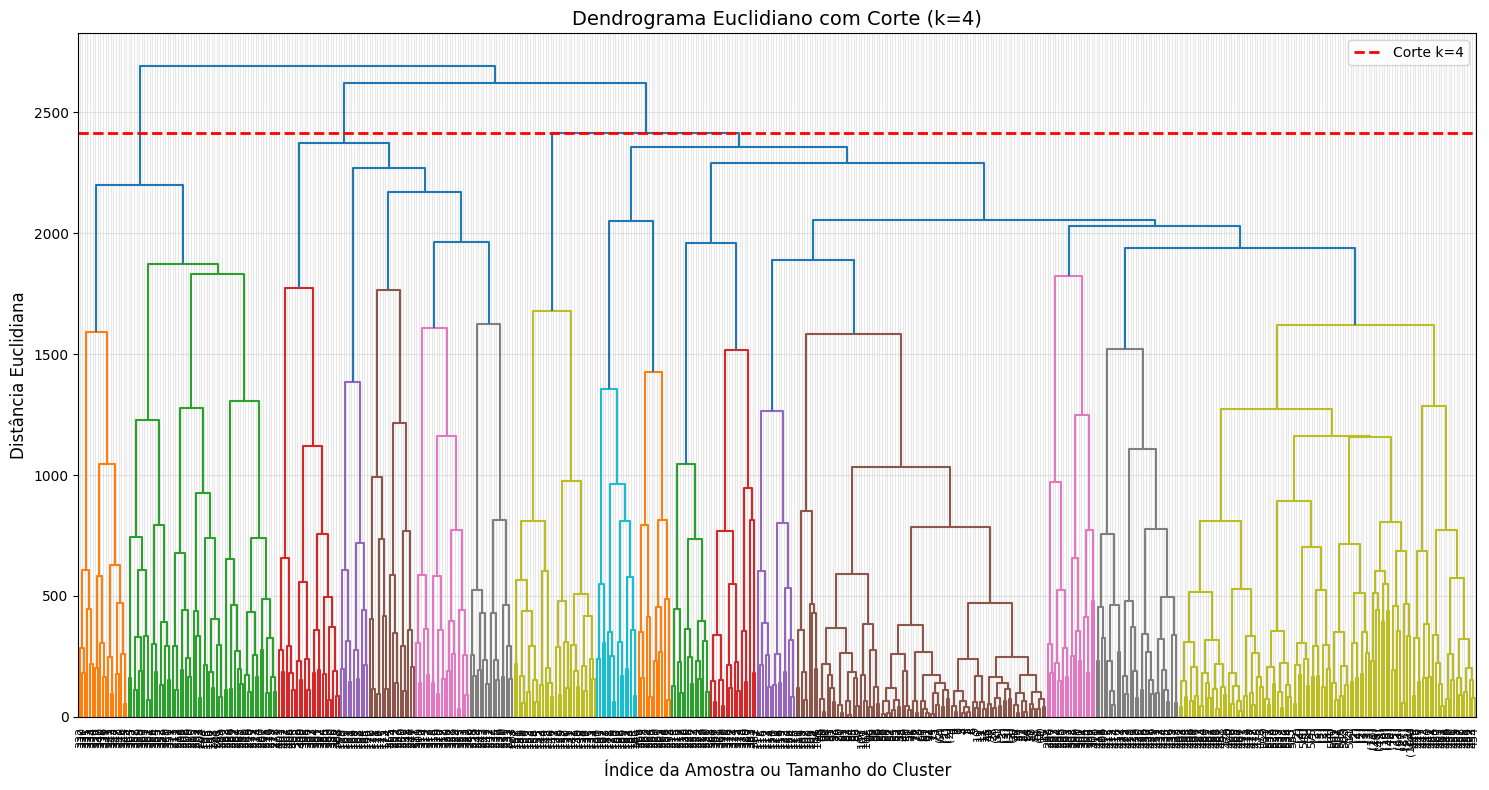

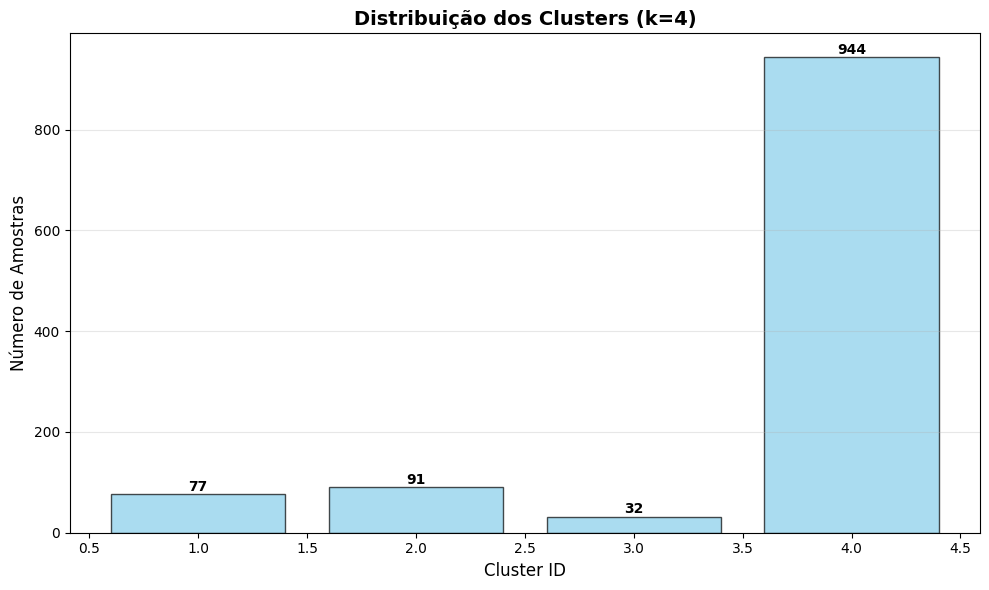

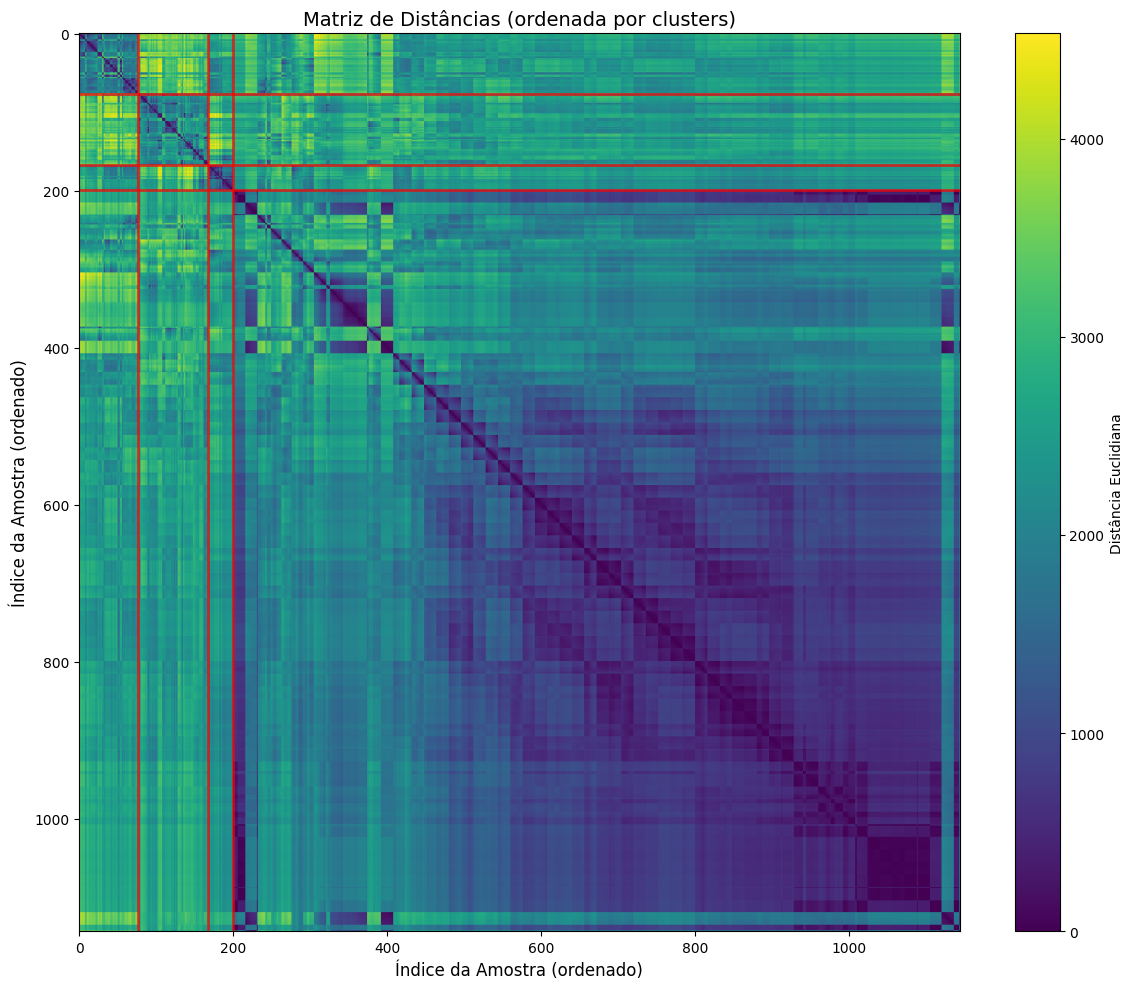

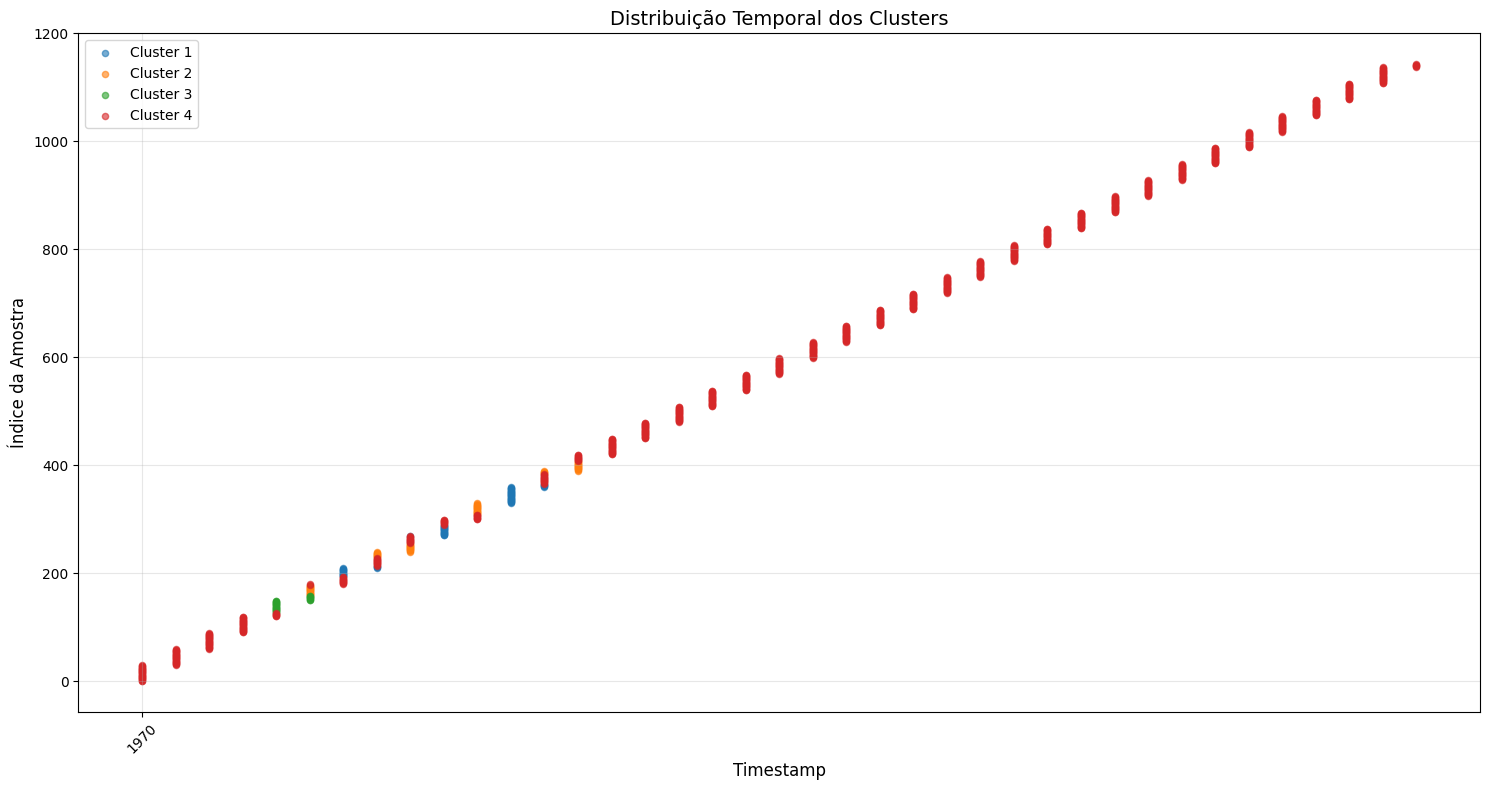


=== ANÁLISE DETALHADA DOS CLUSTERS ===

Cluster 1 (77 amostras):
  Porcentagem: 6.7%
  Índices: 194-365
  Distância intra-cluster média: 1774.160
  Distância intra-cluster std: 666.914

Cluster 2 (91 amostras):
  Porcentagem: 8.0%
  Índices: 159-407
  Distância intra-cluster média: 2046.841
  Distância intra-cluster std: 635.875

Cluster 3 (32 amostras):
  Porcentagem: 2.8%
  Índices: 127-158
  Distância intra-cluster média: 1180.409
  Distância intra-cluster std: 588.649

Cluster 4 (944 amostras):
  Porcentagem: 82.5%
  Índices: 0-1143
  Distância intra-cluster média: 1394.896
  Distância intra-cluster std: 745.676


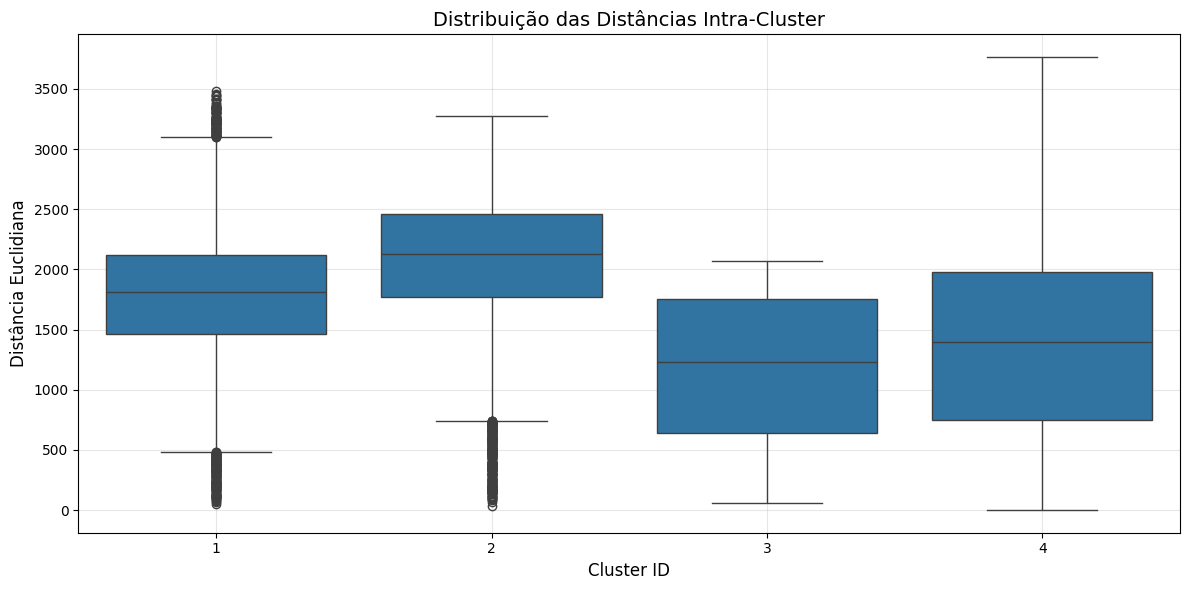


✅ Análise completa finalizada!
📊 Silhouette Score: 0.376


In [14]:
def cut_and_analyze_euclidean_dendrogram(dist_matrix_euclidean, linked_euclidean, optimal_k, df=None):
    """
    Faz o corte do dendrograma no número ótimo de clusters e plota análises
    para clusterização com distância euclidiana customizada
    
    Parameters:
    dist_matrix_euclidean: matriz de distâncias euclidianas
    linked_euclidean: linkage matrix do dendrograma
    optimal_k: número ótimo de clusters encontrado anteriormente
    df: DataFrame original (opcional, para análise temporal)
    """
    
    # Fazer o corte no dendrograma
    cluster_labels = fcluster(linked_euclidean, optimal_k, criterion='maxclust')
    
    # Calcular silhouette score
    silhouette = silhouette_score(dist_matrix_euclidean, cluster_labels, metric='precomputed')
    
    print(f"Número de clusters: {optimal_k}")
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Número total de amostras: {len(cluster_labels)}")
    
    # 1. Plot dendrograma com linha de corte
    plt.figure(figsize=(15, 8))
    dendrogram(linked_euclidean, 
        truncate_mode='level',
        p=15,
        leaf_rotation=90, 
        leaf_font_size=8)

    # Calcular altura do corte
    cut_height = linked_euclidean[-optimal_k+1, 2]  # Altura correspondente ao corte
    plt.axhline(y=cut_height, color='r', linestyle='--', linewidth=2, 
                label=f'Corte k={optimal_k}')
    
    plt.title(f'Dendrograma Euclidiano com Corte (k={optimal_k})', fontsize=14)
    plt.xlabel('Índice da Amostra ou Tamanho do Cluster', fontsize=12)
    plt.ylabel('Distância Euclidiana', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 2. Análise dos clusters - distribuição básica
    unique_labels, counts = np.unique(cluster_labels, return_counts=True)
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(unique_labels, counts, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(f'Distribuição dos Clusters (k={optimal_k})', fontsize=14, fontweight='bold')
    plt.xlabel('Cluster ID', fontsize=12)
    plt.ylabel('Número de Amostras', fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Adicionar rótulos nas barras
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5, 
                str(count), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 3. Heatmap da matriz de distância ordenada por clusters
    plt.figure(figsize=(12, 10))
    
    # Reorganizar matriz por clusters
    cluster_order = np.argsort(cluster_labels)
    reordered_dist = dist_matrix_euclidean[np.ix_(cluster_order, cluster_order)]
    reordered_labels = cluster_labels[cluster_order]
    
    # Criar mapa de cores para clusters na lateral
    cluster_colors = plt.cm.Set1(np.linspace(0, 1, optimal_k))
    row_colors = [cluster_colors[label-1] for label in reordered_labels]
    
    # Plot heatmap
    im = plt.imshow(reordered_dist, cmap='viridis', aspect='auto')
    plt.colorbar(im, label='Distância Euclidiana')
    plt.title('Matriz de Distâncias (ordenada por clusters)', fontsize=14)
    plt.xlabel('Índice da Amostra (ordenado)', fontsize=12)
    plt.ylabel('Índice da Amostra (ordenado)', fontsize=12)
    
    # Adicionar linhas separando clusters
    cluster_boundaries = []
    current_cluster = reordered_labels[0]
    for i, cluster in enumerate(reordered_labels):
        if cluster != current_cluster:
            cluster_boundaries.append(i)
            current_cluster = cluster
    
    for boundary in cluster_boundaries:
        plt.axhline(y=boundary-0.5, color='red', linewidth=2, alpha=0.7)
        plt.axvline(x=boundary-0.5, color='red', linewidth=2, alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # 4. Análise temporal (se DataFrame disponível)
    if df is not None and 'timestamp' in df.columns:
        plt.figure(figsize=(15, 8))
        
        # Extrair informações temporais
        timestamps = pd.to_datetime(df['timestamp'])
        
        # Plot timeline colorido por cluster
        for cluster_id in unique_labels:
            mask = cluster_labels == cluster_id
            cluster_times = timestamps[mask]
            cluster_indices = np.where(mask)[0]
            
            plt.scatter(cluster_times, cluster_indices, 
                       label=f'Cluster {cluster_id}', 
                       alpha=0.6, s=20)
        
        plt.title('Distribuição Temporal dos Clusters', fontsize=14)
        plt.xlabel('Timestamp', fontsize=12)
        plt.ylabel('Índice da Amostra', fontsize=12)
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # 5. Relatório detalhado por cluster
    print("\n=== ANÁLISE DETALHADA DOS CLUSTERS ===")
    cluster_df = pd.DataFrame({
        'Sample_Index': range(len(cluster_labels)),
        'Cluster': cluster_labels
    })
    
    for cluster_id in sorted(unique_labels):
        cluster_data = cluster_df[cluster_df['Cluster'] == cluster_id]
        print(f"\nCluster {cluster_id} ({len(cluster_data)} amostras):")
        print(f"  Porcentagem: {len(cluster_data)/len(cluster_labels)*100:.1f}%")
        print(f"  Índices: {cluster_data['Sample_Index'].min()}-{cluster_data['Sample_Index'].max()}")
        
        # Estatísticas das distâncias intra-cluster
        cluster_indices = cluster_data['Sample_Index'].values
        if len(cluster_indices) > 1:
            intra_distances = []
            for i in range(len(cluster_indices)):
                for j in range(i+1, len(cluster_indices)):
                    idx1, idx2 = cluster_indices[i], cluster_indices[j]
                    intra_distances.append(dist_matrix_euclidean[idx1, idx2])
            
            if intra_distances:
                print(f"  Distância intra-cluster média: {np.mean(intra_distances):.3f}")
                print(f"  Distância intra-cluster std: {np.std(intra_distances):.3f}")
    
    # 6. Boxplot das distâncias por cluster
    plt.figure(figsize=(12, 6))
    
    cluster_distances = []
    cluster_ids = []
    
    for cluster_id in unique_labels:
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        if len(cluster_indices) > 1:
            for i in range(len(cluster_indices)):
                for j in range(i+1, len(cluster_indices)):
                    idx1, idx2 = cluster_indices[i], cluster_indices[j]
                    cluster_distances.append(dist_matrix_euclidean[idx1, idx2])
                    cluster_ids.append(cluster_id)
    
    if cluster_distances:
        df_distances = pd.DataFrame({
            'Cluster': cluster_ids,
            'Distance': cluster_distances
        })
        
        sns.boxplot(data=df_distances, x='Cluster', y='Distance')
        plt.title('Distribuição das Distâncias Intra-Cluster', fontsize=14)
        plt.xlabel('Cluster ID', fontsize=12)
        plt.ylabel('Distância Euclidiana', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    return cluster_df, silhouette, cluster_labels

# Exemplo de uso (substitua os valores pelos seus dados)
# Assumindo que você já executou o código anterior e tem dist_matrix_euclidean e linked
optimal_k = 4  # Substitua pelo seu valor ótimo

# Executar análise
try:
    cluster_df, silhouette, cluster_labels = cut_and_analyze_euclidean_dendrogram(
        dist_matrix_euclidean, linked_euclidean, optimal_k, df
    )
    print(f"\n✅ Análise completa finalizada!")
    print(f"📊 Silhouette Score: {silhouette:.3f}")
    
except NameError as e:
    print(f"⚠️  Erro: Variável não encontrada - {e}")
    print("Execute primeiro o código de clusterização euclidiana para gerar as variáveis necessárias.")

## Analise da Clusterização do DTW

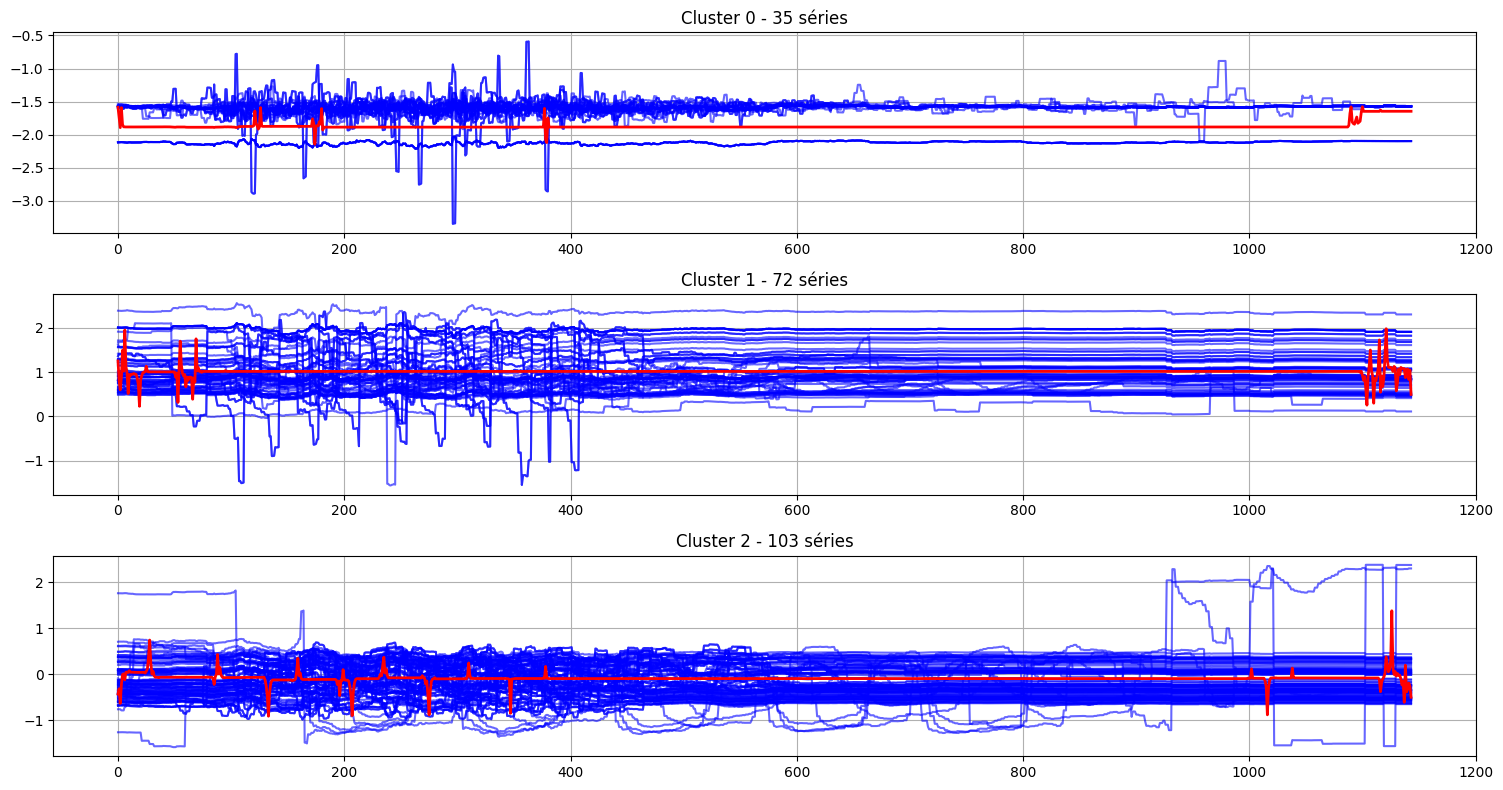

In [ ]:
#usar esse código apos eu realizar a clusterização com mais clusters e ter as métricas para selecioanar o melhor n_clusters
labels = km_dtw.labels_
n_clusters = km_dtw.n_clusters

plt.figure(figsize=(15, 8))
for cluster_id in range(n_clusters):
    plt.subplot(n_clusters, 1, cluster_id + 1)
    
    # Seleciona todas as séries do cluster atual
    cluster_series = X_scaled[labels == cluster_id]
    
    # Plota todas as séries em cinza claro
    for serie in cluster_series:
        plt.plot(serie, color="blue", alpha=0.6)
    
    # Plota o centróide do cluster em destaque
    plt.plot(km_dtw.cluster_centers_[cluster_id].ravel(), color="red", linewidth=2)
    
    plt.title(f"Cluster {cluster_id} - {cluster_series.shape[0]} séries")
    plt.grid(True)

plt.tight_layout()
plt.show()


## CTW Analysis


Número de clusters: 4
Silhouette Score: 0.200


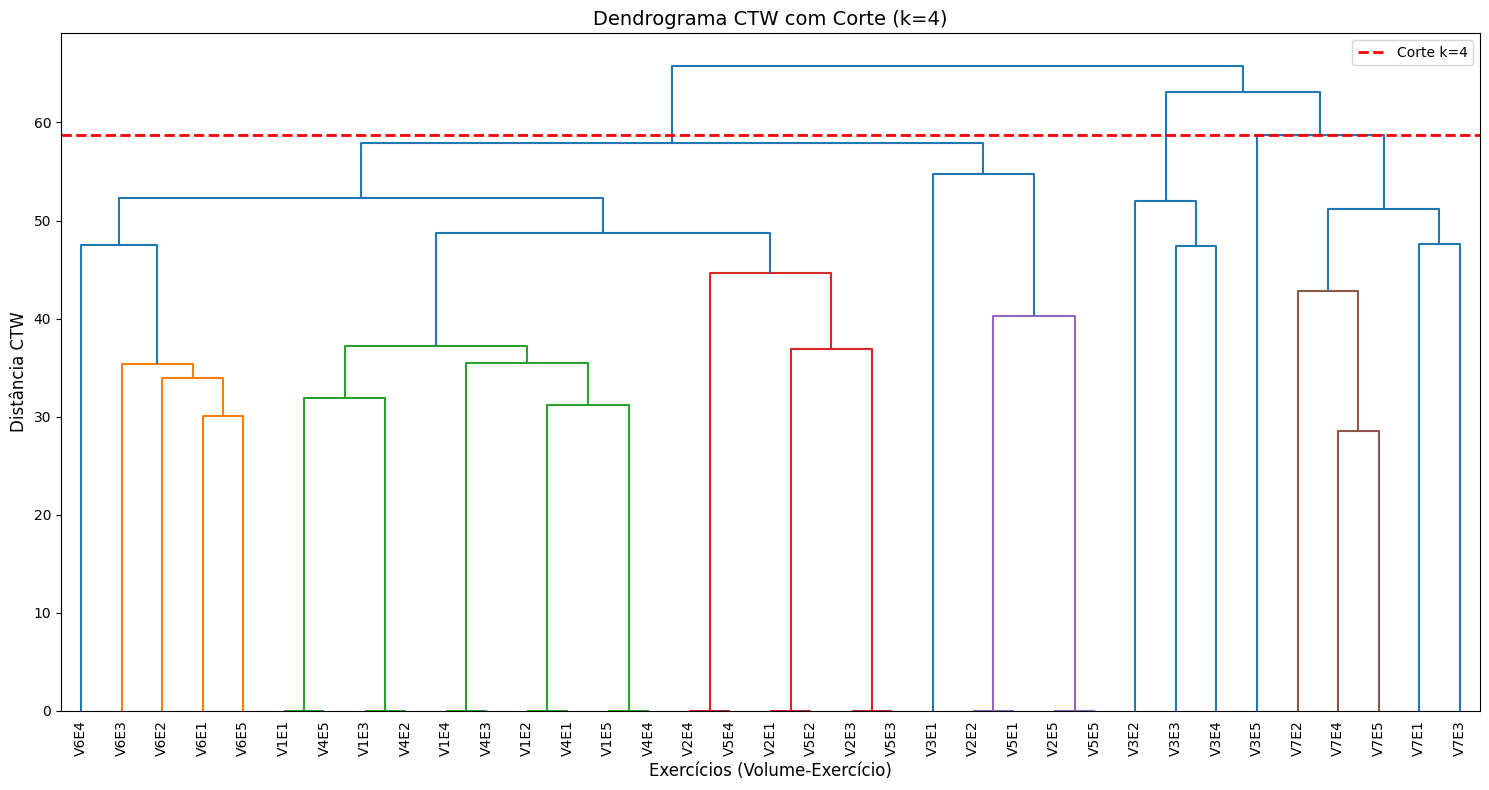

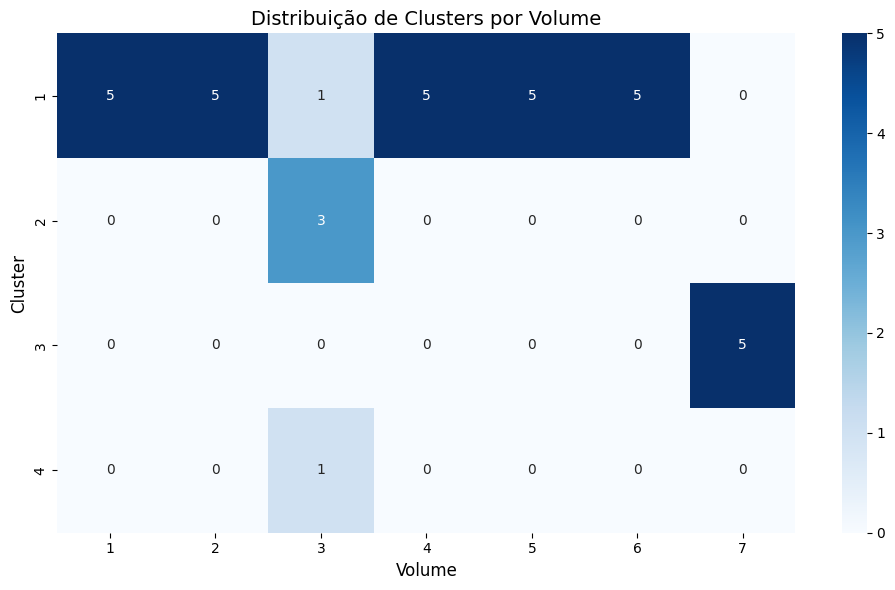

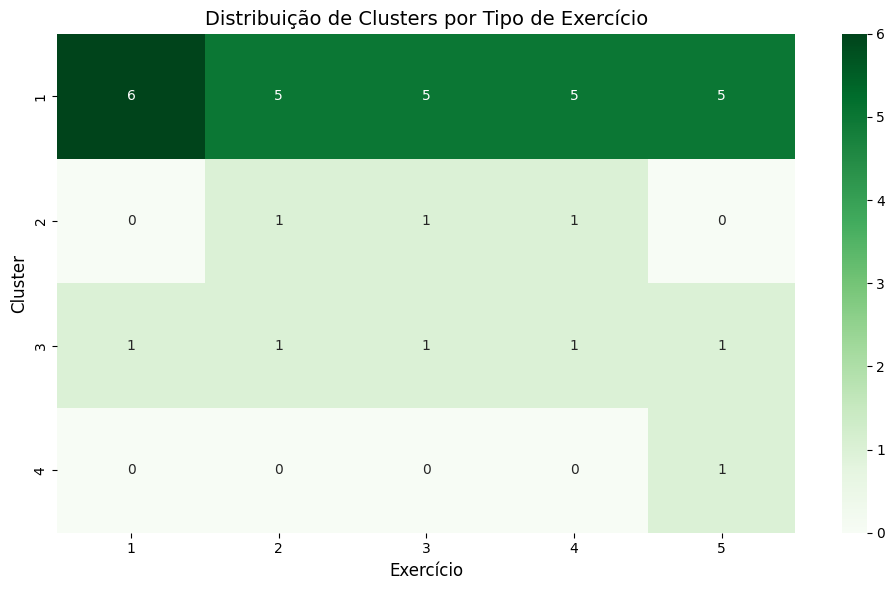


=== ANÁLISE DETALHADA DOS CLUSTERS ===

Cluster 1 (26 exercícios):
  Volumes: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
  Exercícios: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
  Membros: ['V1E1', 'V1E2', 'V1E3', 'V1E4', 'V1E5', 'V2E1', 'V2E2', 'V2E3', 'V2E4', 'V2E5', 'V3E1', 'V4E1', 'V4E2', 'V4E3', 'V4E4', 'V4E5', 'V5E1', 'V5E2', 'V5E3', 'V5E4', 'V5E5', 'V6E1', 'V6E2', 'V6E3', 'V6E4', 'V6E5']

Cluster 2 (3 exercícios):
  Volumes: [np.int64(3)]
  Exercícios: [np.int64(2), np.int64(3), np.int64(4)]
  Membros: ['V3E2', 'V3E3', 'V3E4']

Cluster 3 (5 exercícios):
  Volumes: [np.int64(7)]
  Exercícios: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
  Membros: ['V7E1', 'V7E2', 'V7E3', 'V7E4', 'V7E5']

Cluster 4 (1 exercícios):
  Volumes: [np.int64(3)]
  Exercícios: [np.int64(5)]
  Membros: ['V3E5']


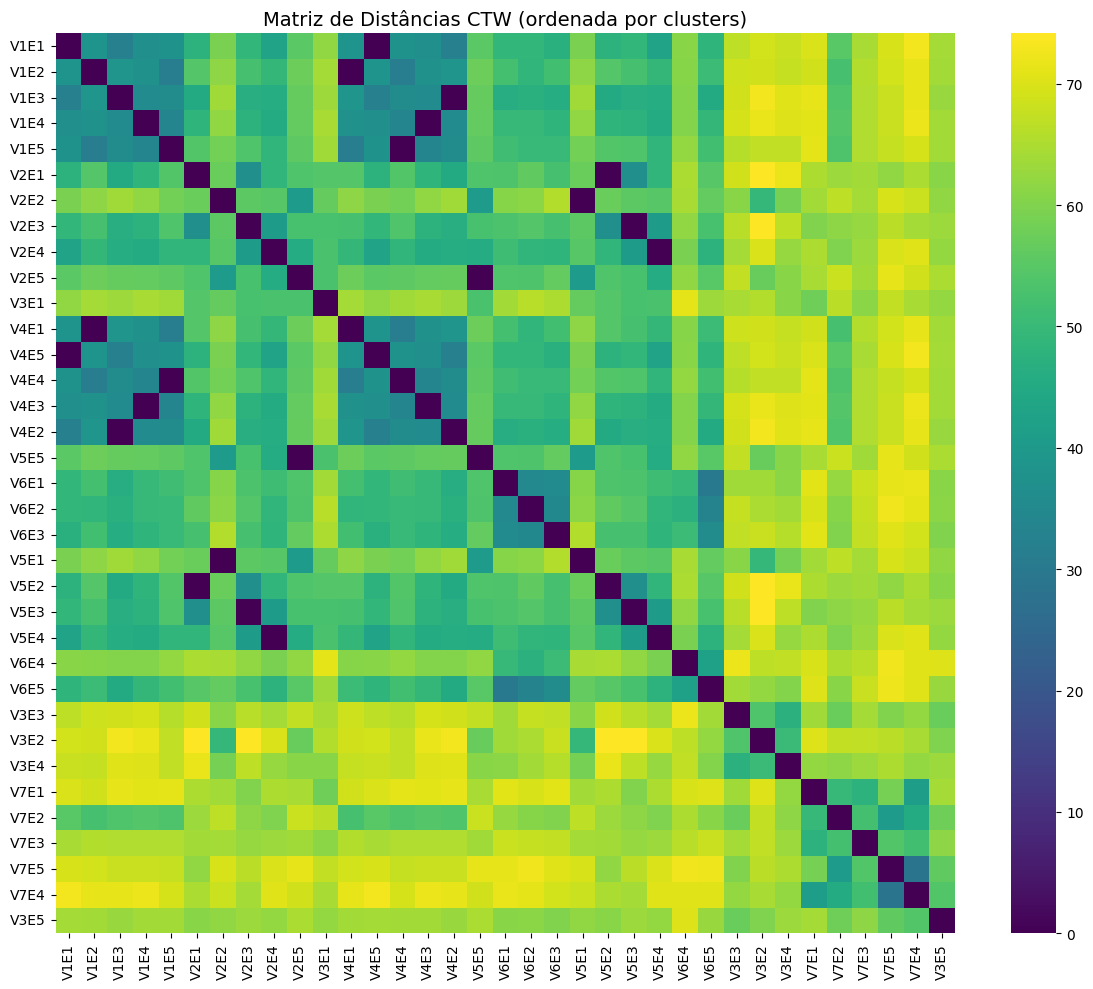

In [48]:
def cut_and_analyze_dendrogram(Z, dist_matrix_ctw, labels, optimal_k):
    """
    Faz o corte do dendrograma no número ótimo de clusters e plota análises
    
    Parameters:
    Z: linkage matrix do dendrograma
    dist_matrix_ctw: matriz de distâncias CTW
    labels: rótulos das séries temporais
    optimal_k: número ótimo de clusters encontrado anteriormente
    """
    
    # Fazer o corte no dendrograma
    cluster_labels = fcluster(Z, optimal_k, criterion='maxclust')
    
    # Calcular silhouette score
    from scipy.spatial.distance import squareform
    condensed_dist = squareform(dist_matrix_ctw)
    X_2d = dist_matrix_ctw  # Use distance matrix for silhouette
    
    # Para silhouette com matriz de distância precomputada
    silhouette = silhouette_score(dist_matrix_ctw, cluster_labels, metric='precomputed')
    
    print(f"Número de clusters: {optimal_k}")
    print(f"Silhouette Score: {silhouette:.3f}")
    
    # 1. Plot dendrograma com linha de corte
    plt.figure(figsize=(15, 8))
    dendrogram_plot = dendrogram(Z, labels=labels, leaf_rotation=90, leaf_font_size=10)
    
    # Calcular altura do corte
    cut_height = Z[-optimal_k+1, 2]  # Altura correspondente ao corte
    plt.axhline(y=cut_height, color='r', linestyle='--', linewidth=2, 
                label=f'Corte k={optimal_k}')
    
    plt.title(f'Dendrograma CTW com Corte (k={optimal_k})', fontsize=14)
    plt.xlabel('Exercícios (Volume-Exercício)', fontsize=12)
    plt.ylabel('Distância CTW', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Análise dos clusters
    cluster_df = pd.DataFrame({
        'Exercicio': labels,
        'Cluster': cluster_labels,
        'Volume': [int(label[1]) for label in labels],
        'Exercicio_Num': [int(label[3]) for label in labels]
    })
    
    # Heatmap da distribuição clusters vs volumes
    plt.figure(figsize=(10, 6))
    cluster_volume = pd.crosstab(cluster_df['Cluster'], cluster_df['Volume'])
    sns.heatmap(cluster_volume, annot=True, cmap='Blues', fmt='d')
    plt.title('Distribuição de Clusters por Volume', fontsize=14)
    plt.xlabel('Volume', fontsize=12)
    plt.ylabel('Cluster', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Heatmap da distribuição clusters vs exercícios
    plt.figure(figsize=(10, 6))
    cluster_exercise = pd.crosstab(cluster_df['Cluster'], cluster_df['Exercicio_Num'])
    sns.heatmap(cluster_exercise, annot=True, cmap='Greens', fmt='d')
    plt.title('Distribuição de Clusters por Tipo de Exercício', fontsize=14)
    plt.xlabel('Exercício', fontsize=12)
    plt.ylabel('Cluster', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Relatório detalhado por cluster
    print("\n=== ANÁLISE DETALHADA DOS CLUSTERS ===")
    for cluster_id in sorted(cluster_df['Cluster'].unique()):
        cluster_data = cluster_df[cluster_df['Cluster'] == cluster_id]
        print(f"\nCluster {cluster_id} ({len(cluster_data)} exercícios):")
        print(f"  Volumes: {sorted(cluster_data['Volume'].unique())}")
        print(f"  Exercícios: {sorted(cluster_data['Exercicio_Num'].unique())}")
        print(f"  Membros: {list(cluster_data['Exercicio'])}")
    
    # Matriz de distância por cluster
    plt.figure(figsize=(12, 10))
    
    # Reorganizar matriz por clusters
    cluster_order = cluster_df.sort_values('Cluster').index
    reordered_dist = dist_matrix_ctw[np.ix_(cluster_order, cluster_order)]
    reordered_labels = [labels[i] for i in cluster_order]
    
    sns.heatmap(reordered_dist, 
                xticklabels=reordered_labels, 
                yticklabels=reordered_labels,
                cmap='viridis')
    plt.title('Matriz de Distâncias CTW (ordenada por clusters)', fontsize=14)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return cluster_df, silhouette

optimal_k = 4  # Substitua pelo seu valor ótimo
cluster_df, silhouette = cut_and_analyze_dendrogram(Z, dist_matrix_ctw, labels, optimal_k)

In [24]:
# Conclusão


A análise revelou que diferentes métodos de clusterização identificam agrupamentos distintos nos dados, que aponta que algoritmos variam na sensibilidade a ruídos, densidade e formato dos clusters.

Os resultados do K-Means indicam agrupamentos mais esféricos, enquanto a clusterização hierárquica forneceu insights sobre a relação hierárquica entre exercícios e voluntários, sendo usando dois métodos apra calcular as distâncias entre as séries para entender proximidade entre movimentos.

Conforme análises técnicas como DTW (Dynamic Time Warping) para comparar padrões temporais de forma mais robusta, dado que deslocamentos temporais podem mascarar similaridades.

Assim, os clusters obtidos podem ser interpretados como padrões biomecânicos semelhantes entre diferentes voluntários e exercícios, possivelmente relacionados a estilos de execução, nível de experiência ou fadiga muscular.
